In [52]:
import pandas as pd
import numpy as np
import xgboost as xgb

import sklearn.model_selection as ms
import sklearn.preprocessing as sp
import sklearn.metrics as sm

from xgboost import XGBRegressor
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [30]:
train = pd.read_csv('../allstate-claims-severity/train.csv')
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [31]:
# target 
train['log_loss'] = np.log(train['loss'])

In [32]:
features = [x for x in train.columns if x not in ['id', 'loss', 'log_loss']]

cat_features = [cat for cat in train.select_dtypes(include=['object']) if cat not in ['id', 'loss', 'log_loss']]

cont_features = [cont for cont in train.select_dtypes(exclude=['object']) if cont not in ['id', 'loss', 'log_loss']]

In [33]:
len(features), len(cat_features), len(cont_features), len(train.columns)

(130, 116, 14, 133)

In [34]:
train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
print('Xtrain:',train_x.shape)
print('ytrain:',train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


In [35]:
train_x

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0,1,0,0,0,0,0,0,1,0,...,0.939556,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216
188314,0,0,0,0,0,1,0,0,0,0,...,0.704268,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872
188315,0,1,0,0,0,0,0,1,1,0,...,0.482436,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888
188316,0,1,0,0,0,0,0,0,1,1,...,0.340543,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707


In [44]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 130 entries, cat1 to cont14
dtypes: float64(14), int16(2), int8(114)
memory usage: 41.3 MB


## Simple XGBoost model

In [ ]:
#数据类型转换成库可以使用的底层格式。
dtrain = xgb.DMatrix(train_x,train['log_loss'])
dtrain

In [45]:
def xg_eval_mae(yhat,dtrain):
    y = dtrain.get_label()
    return 'mae:', mean_absolute_error(np.exp(y),np.exp(yhat))

# Xgboost Parameters
         
    ·'booster':'gbtree',梯度提升树
    ·'objective': 'multi:softmax', 多分类的问题  
    ·'num_class':10, 类别数，与 multisoftmax 并用
    ·'gamma':损失下降多少才进行分裂
    ·'max_depth':12, 构建树的深度，越大越容易过拟合
    ·'lambda':2, 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    ·'subsample':0.7, 随机采样训练样本 // 取70%的数据训练
    ·'colsample_bytree':0.7, 生成树时进行的列采样
    ·'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
    ·'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
    ·'eta': 0.007, 如同学习率。//后加树 的贡献率
    ·'seed':1000,
    ·'nthread':7, cpu 线程数

In [47]:
xgb_params={
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

train-rmse-mean       0.559226
train-rmse-std        0.000204
test-rmse-mean        0.563389
test-rmse-std         0.000979
train-mae-mean     1210.553792
train-mae-std         1.863851
test-mae-mean      1220.110026
test-mae-std          6.763664
Name: 49, dtype: float64

# Cross Validation

In [49]:
%%time 

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0,
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

[10:20:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objecti

<Axes: >

<Figure size 640x480 with 0 Axes>

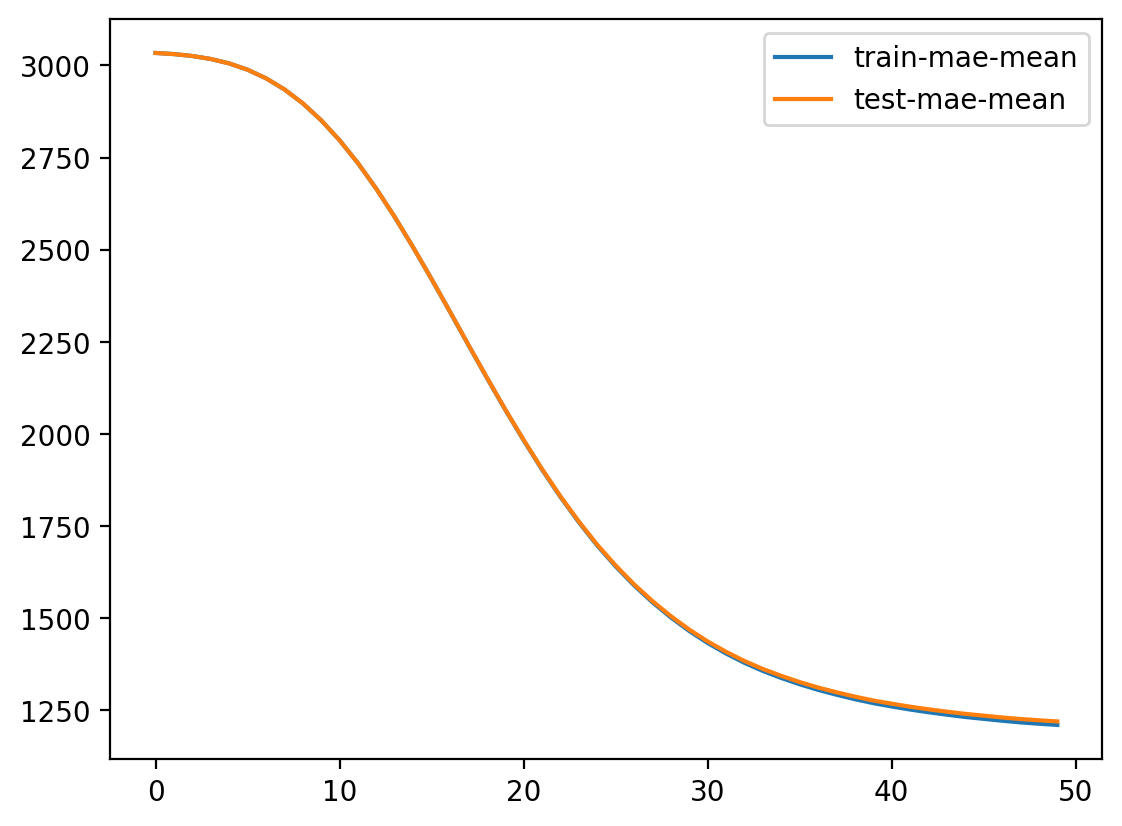

In [55]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

In [62]:
%%time
# using 100 rounds
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

[11:05:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:05:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:05:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objecti

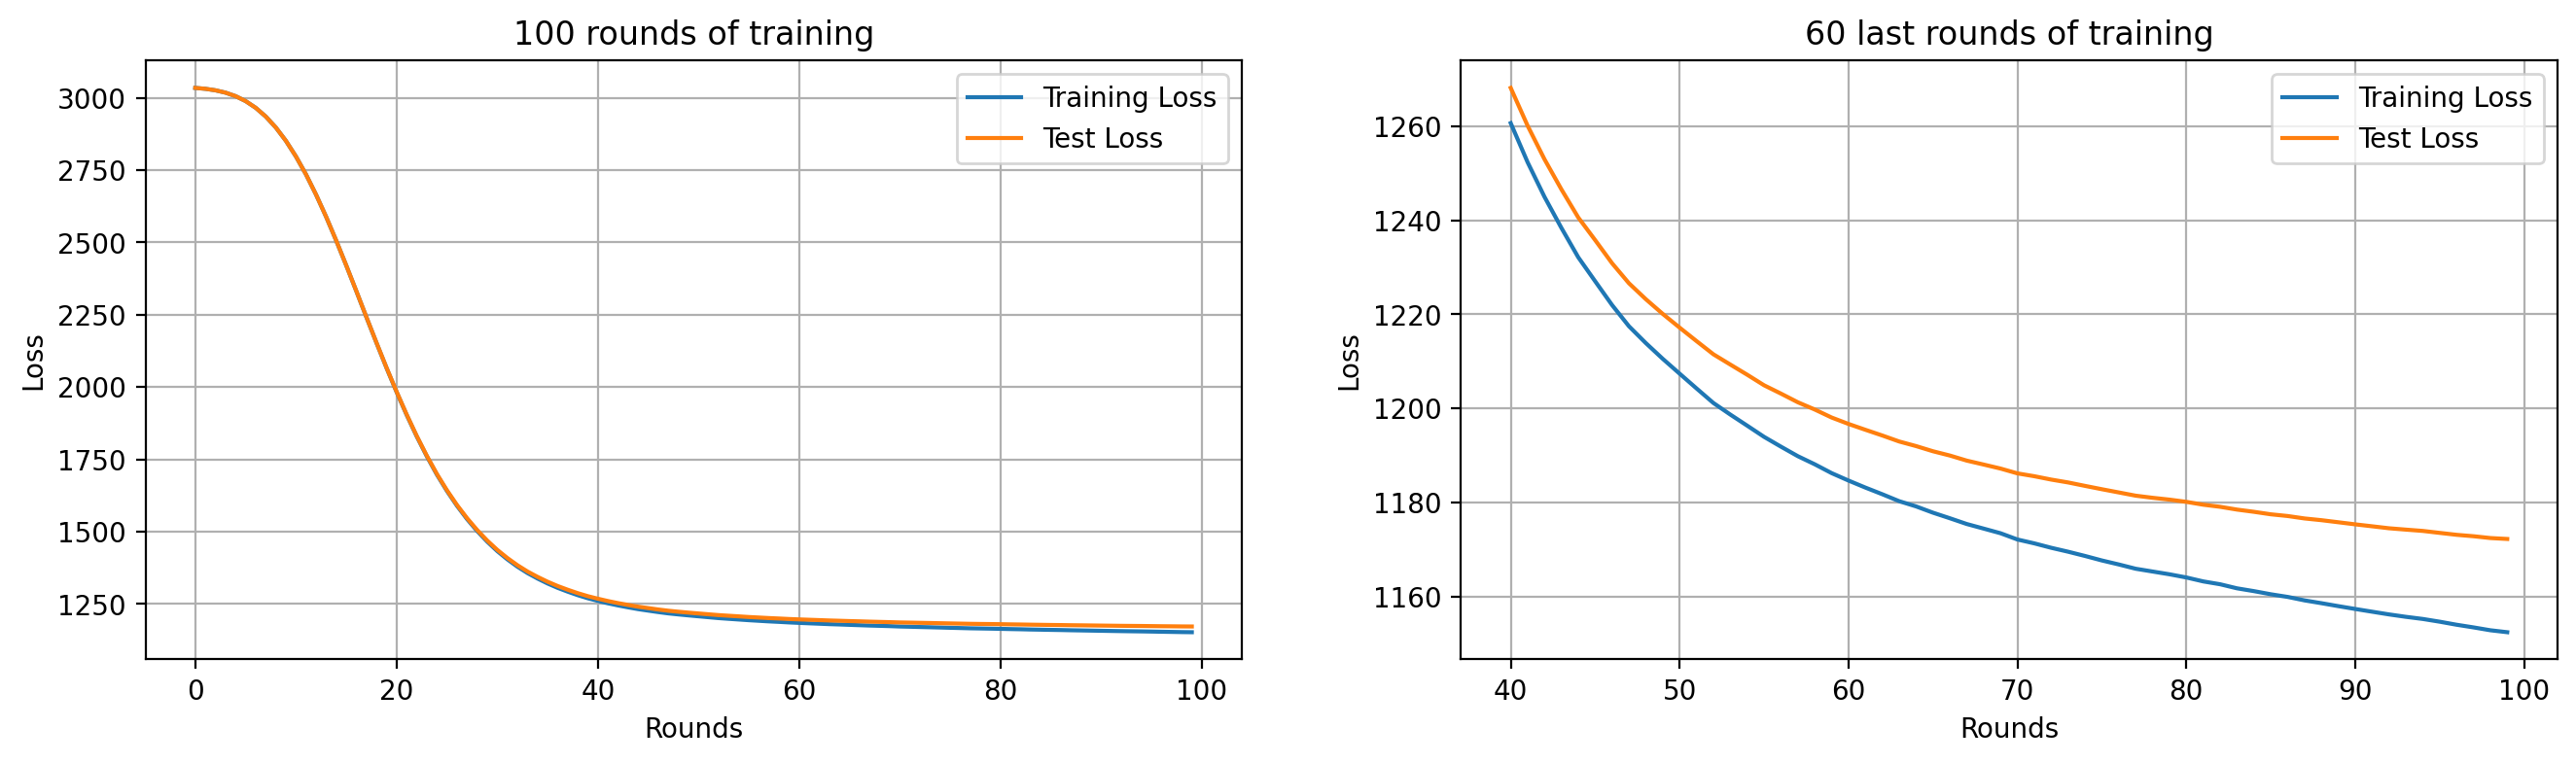

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss']) 

## Step 2: depth & min_child_weight

In [64]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1, 3, 6))}
xgb_param_grid

{'max_depth': [4, 5, 6, 7, 8], 'min_child_weight': [1, 3, 6]}

In [ ]:
# #衡量标准
# def mae_score(y_true, y_pred):
#     return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

# mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(XGBRegressor(eta=0.1, num_boost_round=100,
                    colsample_bytree=0.5, subsample=0.5),param_grid=xgb_param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid.fit(train_x, train_y.values)

网格搜索发现的最佳结果:
{'max_depth': 8, 'min_child_weight': 6}, -1187.9597499123447)

## Step 3: ajust gamma to reduce overfitting

In [71]:
xgb_param_grid = {'gamma': [0.1 * i for i in range(0, 5)]}

grid = GridSearchCV(XGBRegressor(eta=0.1, num_boost_round=100,
                                colsample_bytree=0.5, subsample=0.5), param_grid=xgb_param_grid,
                                cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid.fit(train_x, train_y.values)

## Step 4: adjust subsample and colsample_bytree

In [74]:
xgb_param_grid = {'subsample':[0.1*i for i in range(6,9)],
                'colsample_bytree':[0.1*i for i in range(6, 9)]}

In [76]:
grid = GridSearchCV(XGBRegressor(eta=0.1, num_boost_round=100, gamma=0.2,
                                 max_depth=8, min_child_weight=6), 
                    param_grid=xgb_param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

In [ ]:
grid.fit(train_x, train_y.values)

## Step 5: reduce learning rate and add more trees

In [77]:
xgb_param_grid = {'eta':[0.5, 0.4, 0.3, 0.2, 0.1, 0.75, 0.25, 0.05, 0.02]}
grid = GridSearchCV(XGBRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, verbose=1, n_jobs=-1, scoring='neg_mean_absolute_error')

In [ ]:
grid.fit(train_x, train_y.values)

In [ ]:
# same but increase the number of trees up to 100
grid = GridSearchCV(XGBRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, verbose=1, n_jobs=-1, scoring='neg_mean_absolute_error')